In [522]:
from collections import defaultdict
from __future__ import print_function

import copy
import os
import itertools
import operator
import pickle
import random
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
% matplotlib inline

In [523]:
# Environment Parameters
GRID_HEIGHT = 4 
GRID_WIDTH = 12
TIME_PENALTY = -1
FALL_PENALTY = -100
START = (1,1)
GOAL = (GRID_WIDTH, 1)
ACTIONS = [
    (0, 1),  #UP
    (0, -1), #DOWN
    (1, 0),  #RIGHT
    (-1, 0)  #LEFT
]
ACTION_PLOT = {
    (0, 1) : u'\u2191',
    (0, -1) : u'\u2193',
    (1, 0) : u'\u2192',
    (-1, 0) : u'\u2190',
    None : '-'
}
STATE_LISTS = [range(1, GRID_WIDTH + 1), range(1, GRID_HEIGHT + 1)]
STATES = list(itertools.product(*STATE_LISTS))
NUM_EPISODES = 500
# Epsilon for epsilon greedy agent.
EPSILON = 0.1
ALPHA = 0.8
GAMMA = 0.5

In [524]:
STATES

[(1, 1),
 (1, 2),
 (1, 3),
 (1, 4),
 (2, 1),
 (2, 2),
 (2, 3),
 (2, 4),
 (3, 1),
 (3, 2),
 (3, 3),
 (3, 4),
 (4, 1),
 (4, 2),
 (4, 3),
 (4, 4),
 (5, 1),
 (5, 2),
 (5, 3),
 (5, 4),
 (6, 1),
 (6, 2),
 (6, 3),
 (6, 4),
 (7, 1),
 (7, 2),
 (7, 3),
 (7, 4),
 (8, 1),
 (8, 2),
 (8, 3),
 (8, 4),
 (9, 1),
 (9, 2),
 (9, 3),
 (9, 4),
 (10, 1),
 (10, 2),
 (10, 3),
 (10, 4),
 (11, 1),
 (11, 2),
 (11, 3),
 (11, 4),
 (12, 1),
 (12, 2),
 (12, 3),
 (12, 4)]

In [525]:
def is_valid_state(state):
    x, y = state[0], state[1]
    return x in range(1, GRID_WIDTH + 1) and y in range(1, GRID_HEIGHT + 1)

def is_start_state(state):
    assert is_valid_state(state)
    return state == START

def is_goal_state(state):
    assert is_valid_state(state)
    return state == GOAL

def is_cliff_state(state):
    assert is_valid_state(state)
    x, y = state[0], state[1]
    return (y == 1) and (not is_start_state(state)) and (not is_goal_state(state))

def is_terminal_state(state):
    return is_goal_state(state) or is_cliff_state(state)

# NOTE : This can return invalid states if action is invalid.
def get_next_state(state, action):
    if is_terminal_state(state):
        return state
    return tuple(map(operator.add, state, action))

def get_valid_actions(state):
    # There are no actions in terminal states. We return all actions since reward for terminal states is 0
    # and get_next_state is designed to not make any transitions in terminal states.
    if is_terminal_state(state):
        return ACTIONS
    valid_actions = []
    for action in ACTIONS:
        if is_valid_state(get_next_state(state, action)):
            valid_actions.append(action)
    return valid_actions

def act(state, action):
    assert not is_terminal_state(state)
    next_state = get_next_state(state, action)
    if is_cliff_state(next_state):
        reward = FALL_PENALTY
    elif is_goal_state(next_state):
        reward = 0
    else:
        reward = TIME_PENALTY
    return next_state, reward

def init_q(Q):
    for state in STATES:
        valid_actions = get_valid_actions(state)
        for action in valid_actions:
            next_state = get_next_state(state, action)
            if is_valid_state(next_state):
                Q[state][action] = 0

In [526]:
def get_random_action(state):
    # For non-terminal states there is atleast one valid action.
    # For terminal states it doesn't matter what action we return since all have reward 0.    
    valid_actions = get_valid_actions(state)
    assert len(valid_actions) > 0
    return random.choice(valid_actions)

def get_greedy_action(Q, state):
    return max(Q[state], key=Q[state].get)

def get_epsilon_greedy_action(Q, state):
    # Choose an exploratory action with probability epsilon
    if random.random() < EPSILON:
#         print('Returning Random Choice')
        return get_random_action(state)
    # Return greedy action
    return get_greedy_action(Q, state)

def get_optimal_policy(Q, state):
    optimal_policy = {} 
    visited = {}
    while not is_terminal_state(state):
        optimal_action = get_greedy_action(Q, state)
        optimal_policy[state] = optimal_action
        visited[state] = True
        state = get_next_state(state, optimal_action)
        if state in visited:
            break
    return optimal_policy

def plot_policy(policy):
    for y in reversed(xrange(1, GRID_HEIGHT + 1)):
        print('')
        for x in xrange(1, GRID_WIDTH + 1):
            state = (x,y)
            action = policy[state] if state in policy else None
            print('%s\t' %(ACTION_PLOT[action]), end='')

def get_smoothed_rewards(rewards, window_size = 10):
    num_episodes = len(rewards)
    smoothed_rewards = []
    cur_reward = sum(rewards[:window_size])
    smoothed_rewards.append(cur_reward * 1.0 / window_size)
    for i in xrange(window_size, num_episodes):
        cur_reward -= rewards[i-window_size]
        cur_reward += rewards[i]
        smoothed_rewards.append(cur_reward * 1.0 / window_size)
    return smoothed_rewards
    
def plot_smoothed_rewards(sarsa_rewards, qlearning_rewards):
    plt.plot(get_smoothed_rewards(sarsa_rewards))
    plt.plot(get_smoothed_rewards(qlearning_rewards))
    plt.ylabel('Rewards')
    plt.xlabel('Episodes')

In [527]:
def sarsa(num_episodes):
    Q = defaultdict(dict)
    init_q(Q)
    episode_rewards = []
    for episode in xrange(num_episodes):
        print('Episode {0}'.format(episode))
        state = START
        action = get_epsilon_greedy_action(Q, state)
        episode_reward = 0
        print('EpsilonGreedyAction is : {0}'.format(action))
        while not is_terminal_state(state):
            next_state, reward = act(state, action)
            episode_reward += reward
            next_action = get_epsilon_greedy_action(Q, next_state)
#             print('State:{0} Action:{1} Reward{2} NextState:{3} NextAction{4}'.format(state, action, reward,
#                                                                                       next_state, next_action))
            Q[state][action] += ALPHA * (reward + GAMMA * Q[next_state][next_action] - Q[state][action])
            state, action = next_state, next_action
        episode_rewards.append(episode_reward)
    optimal_policy = get_optimal_policy(Q, START)
    return episode_rewards, optimal_policy, Q

def qlearning(num_episodes):
    Q = defaultdict(dict)
    init_q(Q)
    episode_rewards = []
    for episode in xrange(num_episodes):
        print('Episode {0}'.format(episode))
        state = START
        action = get_epsilon_greedy_action(Q, state)
        episode_reward = 0
        print('EpsilonGreedyAction is : {0}'.format(action))
        while not is_terminal_state(state):
            next_state, reward = act(state, action)
            episode_reward += reward
            next_action = get_epsilon_greedy_action(Q, next_state)
#             print('State:{0} Action:{1} Reward{2} NextState:{3} NextAction{4}'.format(state, action, reward,
#                                                                                       next_state, next_action))
            greedy_action = get_greedy_action(Q, next_state)
            Q[state][action] += ALPHA * (reward + GAMMA * Q[next_state][greedy_action] - Q[state][action])
            state, action = next_state, next_action
        episode_rewards.append(episode_reward)
    optimal_policy = get_optimal_policy(Q, START)
    return episode_rewards, optimal_policy, Q

In [528]:
sarsa_rewards, sarsa_policy, _ = sarsa(NUM_EPISODES)

Episode 0
EpsilonGreedyAction is : (0, 1)
Episode 1
EpsilonGreedyAction is : (0, 1)
Episode 2
EpsilonGreedyAction is : (0, 1)
Episode 3
EpsilonGreedyAction is : (0, 1)
Episode 4
EpsilonGreedyAction is : (0, 1)
Episode 5
EpsilonGreedyAction is : (0, 1)
Episode 6
EpsilonGreedyAction is : (0, 1)
Episode 7
EpsilonGreedyAction is : (0, 1)
Episode 8
EpsilonGreedyAction is : (0, 1)
Episode 9
EpsilonGreedyAction is : (0, 1)
Episode 10
EpsilonGreedyAction is : (0, 1)
Episode 11
EpsilonGreedyAction is : (0, 1)
Episode 12
EpsilonGreedyAction is : (0, 1)
Episode 13
EpsilonGreedyAction is : (0, 1)
Episode 14
EpsilonGreedyAction is : (0, 1)
Episode 15
EpsilonGreedyAction is : (0, 1)
Episode 16
EpsilonGreedyAction is : (0, 1)
Episode 17
EpsilonGreedyAction is : (0, 1)
Episode 18
EpsilonGreedyAction is : (0, 1)
Episode 19
EpsilonGreedyAction is : (0, 1)
Episode 20
EpsilonGreedyAction is : (0, 1)
Episode 21
EpsilonGreedyAction is : (0, 1)
Episode 22
EpsilonGreedyAction is : (0, 1)
Episode 23
EpsilonGre

In [529]:
plot_policy(sarsa_policy)


-	-	-	-	-	-	-	-	-	-	-	-	
-	→	↓	→	←	-	-	-	-	-	-	-	
→	↑	→	↑	-	-	-	-	-	-	-	-	
↑	-	-	-	-	-	-	-	-	-	-	-	

In [530]:
qlearning_rewards, qlearning_policy, _ = qlearning(NUM_EPISODES)

Episode 0
EpsilonGreedyAction is : (0, 1)
Episode 1
EpsilonGreedyAction is : (0, 1)
Episode 2
EpsilonGreedyAction is : (0, 1)
Episode 3
EpsilonGreedyAction is : (0, 1)
Episode 4
EpsilonGreedyAction is : (0, 1)
Episode 5
EpsilonGreedyAction is : (0, 1)
Episode 6
EpsilonGreedyAction is : (0, 1)
Episode 7
EpsilonGreedyAction is : (0, 1)
Episode 8
EpsilonGreedyAction is : (0, 1)
Episode 9
EpsilonGreedyAction is : (0, 1)
Episode 10
EpsilonGreedyAction is : (0, 1)
Episode 11
EpsilonGreedyAction is : (0, 1)
Episode 12
EpsilonGreedyAction is : (0, 1)
Episode 13
EpsilonGreedyAction is : (0, 1)
Episode 14
EpsilonGreedyAction is : (0, 1)
Episode 15
EpsilonGreedyAction is : (0, 1)
Episode 16
EpsilonGreedyAction is : (0, 1)
Episode 17
EpsilonGreedyAction is : (0, 1)
Episode 18
EpsilonGreedyAction is : (0, 1)
Episode 19
EpsilonGreedyAction is : (0, 1)
Episode 20
EpsilonGreedyAction is : (0, 1)
Episode 21
EpsilonGreedyAction is : (0, 1)
Episode 22
EpsilonGreedyAction is : (0, 1)
Episode 23
EpsilonGre

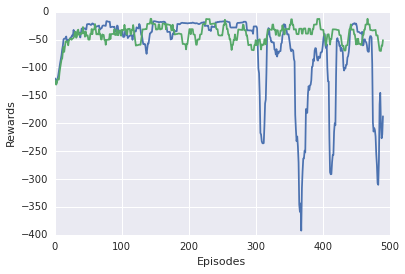

In [531]:
plot_smoothed_rewards(sarsa_rewards, qlearning_rewards)